# Steepest Hill Climb
It refers to moving in the direction of steepest ascent of the reward-policy function. The 
method is not very good though as it may tend to get stuck in local maximas...

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
from collections import deque
%matplotlib inline 

# Agent class
We will work on the cartpole environment as its good for 1st time experimentations. The policy is
going to be a weights matrix which ouputs propabilities for each action. The propabilities 
will be generated using a $softmax$ function. Its given by 

![softmax](https://wikimedia.org/api/rest_v1/media/math/render/svg/02a859ba32ab892a2cdbfdafcd5a8f56e49e3d1c)

Its normaly used in classification problems and hence is also suitable for this one

In [4]:
class HillClimber:
    def __init__(self, env):
        self.n_actions = env.action_space.n
        self.n_observations = env.observation_space.shape[0]
        self.policy = np.random.rand(self.n_observations, self.n_actions)
        self.best_policy = np.copy(self.policy)
        self.best_reward = -1
        self.noise = 0.5
        self.noise_max = 2
        self.noise_min = 0.001
        self.gamma = 0.98
        
    def get_action(self, state, policy=None):
        if not policy:
            actions = np.dot(state, self.policy)
        else:
            actions = np.dot(state, policy)
        actions = np.exp(actions)
        actions = actions / np.sum(actions)
        return np.argmax(actions)
            
    def _noise_adder(self, better):
        if better:
            self.policy += np.random.normal(
                loc=(self.noise_min + self.noise)/2,
                scale=(self.noise - self.noise_min),
                size=(self.n_observations, self.n_actions)
            )
        else:
            self.policy = self.best_policy + np.random.normal(
                loc=(self.noise_min + self.noise)/2,
                scale=(self.noise - self.noise_min),
                size=(self.n_observations, self.n_actions)
            )
            
    def learn(self, discounted_reward):
        if discounted_reward > self.best_reward:
            self.best_reward = discounted_reward
            self.best_policy = self.policy
            if self.noise > self.noise_min:
                self._noise_adder(better=True)
                self.noise = max(self.noise_min, self.noise/2)
        else:
            if self.noise < self.noise_max:
                self._noise_adder(better=False)
                self.noise = min(self.noise_max, self.noise*1.1)
        
    def try_policy(self, env, evaluate=False):
        discounted_reward = 0
        state = env.reset()
        state = np.reshape(state, (1,self.n_observations))
        done = False
        time_steps = 0
        while not done:
            time_steps += 1
            action = self.get_action(state)
            next_state, reward, done, _ = env.step(action)
            if not evaluate:
                discounted_reward += (self.gamma ** time_steps) * reward
            else:
                discounted_reward += reward
                env.render()
            state = next_state
            state = np.reshape(state, (1,self.n_observations))
        return discounted_reward

The environment handler

In [5]:
env = gym.make('CartPole-v1')
EPOCHS = 200
EVAL_FREQ = 5
agent = HillClimber(env)

Epoch : 0    Evaluation Score : 8.0    Noise Scale : 0.25
Epoch : 5    Evaluation Score : 8.0    Noise Scale : 0.18301250000000008
Epoch : 10    Evaluation Score : 9.0    Noise Scale : 0.29474346137500024
Epoch : 15    Evaluation Score : 10.0    Noise Scale : 0.47468729197905185
Epoch : 20    Evaluation Score : 9.0    Noise Scale : 0.7644886306051829
Epoch : 25    Evaluation Score : 9.0    Noise Scale : 1.2312165844759535
Epoch : 30    Evaluation Score : 47.0    Noise Scale : 0.40968731848437356
Epoch : 35    Evaluation Score : 23.0    Noise Scale : 0.29991160149648577
Epoch : 40    Evaluation Score : 21.0    Noise Scale : 0.48301063332610544
Epoch : 45    Evaluation Score : 11.0    Noise Scale : 0.35358793412637557
Epoch : 50    Evaluation Score : 31.0    Noise Scale : 0.5694569037898694
Epoch : 55    Evaluation Score : 30.0    Noise Scale : 0.416870926419374
Epoch : 60    Evaluation Score : 40.0    Noise Scale : 0.3051703616853028
Epoch : 65    Evaluation Score : 12.0    Noise Scale 

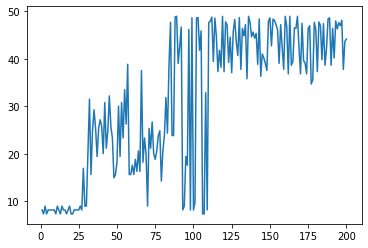

In [6]:
env.seed(1)
np.random.seed(1)
rewards_tracker = deque(maxlen=20)
all_rewards = []
for epoch in range(EPOCHS):
    discounted_reward = agent.try_policy(env)
    all_rewards.append(discounted_reward)
    agent.learn(discounted_reward)
    if not epoch % EVAL_FREQ:
        rewards_tracker.append(agent.try_policy(env, evaluate=True))
        print(f"Epoch : {epoch}    Evaluation Score : {rewards_tracker[-1]}    Noise Scale : {agent.noise}")
    if np.mean(rewards_tracker) > 195.0 or rewards_tracker[-1]==500:
        print(f"Episode Solved in {epoch} epochs!")
        break
env.close()
plt.plot(np.arange(start=1,
                   stop=epoch+2,
                   step=1), all_rewards)

# Evaluation

In [89]:
agent.try_policy(env, evaluate=True)
env.close()

In [ ]:
env.close()